In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

In [21]:
data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')
data['isCancerous'] = data['isCancerous'].astype(str)
data['cellType'] = data['cellType'].astype(str)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

([0, 1], [Text(0, 0, '1'), Text(1, 0, '0')])

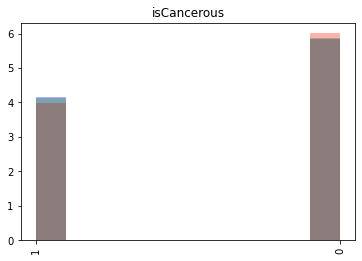

In [22]:
plt.hist(train_data['isCancerous'], alpha=0.3, color='b', label='Train', density=True)
plt.hist(test_data['isCancerous'], alpha=0.3, color='r', label='Test',  density=True)
plt.hist(data['isCancerous'], alpha=0.3, color='g', density=True)
plt.title('isCancerous')
plt.xticks(rotation='vertical')

([0, 1, 2, 3],
 [Text(0, 0, '2'), Text(1, 0, '0'), Text(2, 0, '3'), Text(3, 0, '1')])

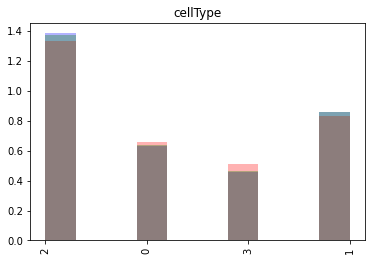

In [23]:
plt.hist(train_data['cellType'], alpha=0.3, color='b', label='Train', density=True)
plt.hist(test_data['cellType'], alpha=0.3, color='r', label='Test',  density=True)
plt.hist(data['cellType'], alpha=0.3, color='g', density=True)
plt.title('cellType')
plt.xticks(rotation='vertical')

In [24]:
class_samples_isCancerous = train_data['isCancerous'].value_counts()
total_samples = np.sum(class_samples_isCancerous)
class_weights_isCancerous = total_samples / class_samples_isCancerous
class_weight_dict_isCancerous = {int(k): v for k, v in class_weights_isCancerous.to_dict().items()}

class_samples_cellType = train_data['cellType'].value_counts()
total_samples = np.sum(class_samples_cellType)
class_weights_cellType = total_samples / class_samples_cellType
class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}

In [25]:
batch_size = 32
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_isCancerous_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

validation_isCancerous_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

Found 7916 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


In [26]:
train_cellType_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

validation_cellType_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


三层卷积，池化。+64，32，16MPL。bc=16，lr=0.001。目前表现最佳。

In [27]:
input_shape = (27, 27, 3)
num_classes = 4
l2_coeff = 0.01

model_binary = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_binary.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 27, 27, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_13 (Bat  (None, 25, 25, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                      

In [28]:
model_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model_categorical.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_18 (Bat  (None, 27, 27, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_19 (Bat  (None, 25, 25, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                      

In [29]:
model_binary.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model_categorical.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [11]:
epochs = 100
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-15)
history_binary = model_binary.fit(
    train_isCancerous_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=validation_isCancerous_generator,
    validation_steps=len(test_data) // batch_size,
    class_weight=class_weight_dict_isCancerous
    , callbacks=[lr_reducer]
)

Epoch 1/100


2023-04-27 16:59:42.811612: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


247/247 [==============================] - 10s 35ms/step - loss: 14.4948 - accuracy: 0.8144 - val_loss: 13.9485 - val_accuracy: 0.3986 - lr: 1.0000e-04
Epoch 2/100
247/247 [==============================] - 8s 33ms/step - loss: 12.9447 - accuracy: 0.8549 - val_loss: 12.0013 - val_accuracy: 0.8453 - lr: 1.0000e-04
Epoch 3/100
247/247 [==============================] - 8s 33ms/step - loss: 11.7220 - accuracy: 0.8568 - val_loss: 10.8136 - val_accuracy: 0.8637 - lr: 1.0000e-04
Epoch 4/100
247/247 [==============================] - 8s 33ms/step - loss: 10.6196 - accuracy: 0.8645 - val_loss: 9.7352 - val_accuracy: 0.9047 - lr: 1.0000e-04
Epoch 5/100
247/247 [==============================] - 8s 33ms/step - loss: 9.6212 - accuracy: 0.8710 - val_loss: 8.8339 - val_accuracy: 0.8878 - lr: 1.0000e-04
Epoch 6/100
247/247 [==============================] - 9s 35ms/step - loss: 8.7589 - accuracy: 0.8753 - val_loss: 8.0795 - val_accuracy: 0.8622 - lr: 1.0000e-04
Epoch 7/100
247/247 [=================

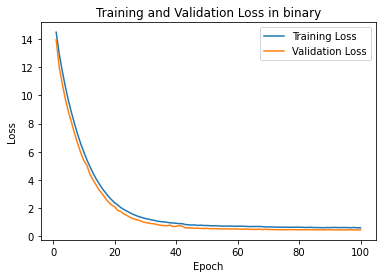

In [12]:
train_loss = history_binary.history['loss']
val_loss = history_binary.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in binary')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

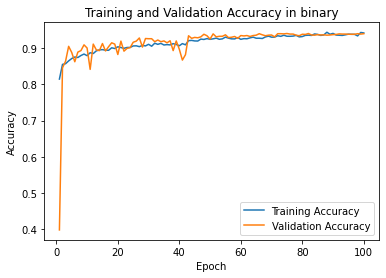

In [13]:
train_accuracy = history_binary.history['accuracy']
val_accuracy = history_binary.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in binary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [14]:
epochs = 50
history_categorical = model_categorical.fit(
    train_cellType_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=validation_cellType_generator,
    validation_steps=len(test_data) // batch_size,
    class_weight=class_weight_dict_cellType
    , callbacks=[lr_reducer]
)

Epoch 1/100
247/247 [==============================] - 11s 40ms/step - loss: 19.3581 - accuracy: 0.5462 - val_loss: 16.1948 - val_accuracy: 0.4544 - lr: 1.0000e-04
Epoch 2/100
247/247 [==============================] - 10s 39ms/step - loss: 18.2842 - accuracy: 0.6185 - val_loss: 14.9718 - val_accuracy: 0.6173 - lr: 1.0000e-04
Epoch 3/100
247/247 [==============================] - 9s 38ms/step - loss: 17.7683 - accuracy: 0.6403 - val_loss: 14.3922 - val_accuracy: 0.6747 - lr: 1.0000e-04
Epoch 4/100
247/247 [==============================] - 9s 38ms/step - loss: 17.2334 - accuracy: 0.6574 - val_loss: 14.0785 - val_accuracy: 0.6706 - lr: 1.0000e-04
Epoch 5/100
247/247 [==============================] - 9s 38ms/step - loss: 16.7433 - accuracy: 0.6684 - val_loss: 14.4104 - val_accuracy: 0.4708 - lr: 1.0000e-04
Epoch 6/100
247/247 [==============================] - 9s 38ms/step - loss: 16.3923 - accuracy: 0.6754 - val_loss: 13.5944 - val_accuracy: 0.6368 - lr: 1.0000e-04
Epoch 7/100
247/247 

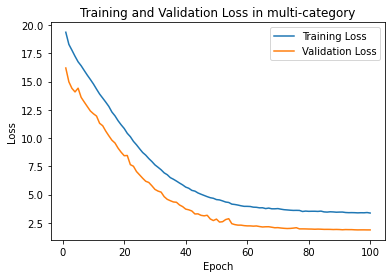

In [15]:
train_loss = history_categorical.history['loss']
val_loss = history_categorical.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in multi-category')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

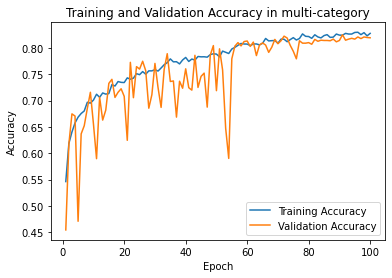

In [16]:
train_accuracy = history_categorical.history['accuracy']
val_accuracy = history_categorical.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in multi-category')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [19]:
model_categorical.save('saved_model/model_categorical')

INFO:tensorflow:Assets written to: saved_model/model_categorical/assets


INFO:tensorflow:Assets written to: saved_model/model_categorical/assets


# DI/HD 使用data_labels_extraData对多分类的模型进行增强
通过半监督学习。我们将采用UDA。
首先先获取额外的数据集并且进行相关处理。
我们从数据集可以观察到，没有癌症在多分类中为2。所以我们可以将不是癌症的样本之间指定其多分类的类别为2.

In [17]:
model_categorical = tf.keras.models.load_model('saved_model/model_categorical')
data_extra = pd.read_csv('./Image_classification_data/data_labels_extraData.csv')
data_extra['isCancerous'] = data_extra['isCancerous'].astype(str)
data_extra['cellType'] = np.nan
data_extra.loc[data_extra['isCancerous'] == '1', 'cellType'] = 2
data_extra_unlabeled = data_extra[data_extra['cellType'].isna()]
data_extra_labeled = data_extra[data_extra['cellType'] == 2]
train_data = pd.concat([train_data, data_extra_labeled], axis=0).reset_index(drop=True)

重新生成新的train_generator

In [18]:
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

unlabeled_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

unlabeled_generator = unlabeled_datagen.flow_from_dataframe(
    data_extra_unlabeled,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col=None,
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

TypeError: If class_mode="categorical", y_col="cellType" column values must be type string, list or tuple.

In [ ]:
consistency_weight = 1
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
# 定义数据增强策略
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

# 训练循环
def apply_uda(x_batch, y_batch, x_unlabeled, model, optimizer):
    # 对无标签数据进行数据增强
    x_unlabeled_augmented = data_augmentation(x_unlabeled)

    # 计算模型在原始无标签数据和增强无标签数据上的输出
    with tf.GradientTape() as tape:
        y_pred_labeled = model(x_batch)
        y_pred_unlabeled = model(x_unlabeled)
        y_pred_unlabeled_augmented = model(x_unlabeled_augmented)

        # 计算有监督损失和一致性损失
        supervised_loss = tf.keras.metrics.categorical_crossentropy(y_batch, y_pred_labeled)
        consistency_loss = tf.keras.metrics.mean_squared_error(y_pred_unlabeled, y_pred_unlabeled_augmented)

        # 计算总损失
        total_loss = supervised_loss + consistency_weight * consistency_loss

        # 计算准确度
        accuracy = tf.keras.metrics.categorical_accuracy(y_batch, y_pred_labeled)

    # 反向传播和优化
    grads = tape.gradient(total_loss, model_categorical.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_categorical.trainable_variables))
    return total_loss, supervised_loss, consistency_loss, accuracy


for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    total_loss = 0
    total_supervised_loss = 0
    total_consistency_loss = 0
    total_accuracy = 0
    steps = 0
    for (x_batch, y_batch), (x_unlabeled, _) in zip(train_generator, unlabeled_generator):
        loss, supervised_loss, consistency_loss, accuracy = apply_uda(x_batch, y_batch, x_unlabeled, model_categorical, optimizer)

        total_loss += loss
        total_supervised_loss += supervised_loss
        total_consistency_loss += consistency_loss
        total_accuracy += accuracy
        steps += 1

        # 打印当前批次的准确率
        print(f" - batch {steps}: accuracy: {accuracy:.4f}")

        # 检查是否已经处理了所有批次
        if steps * batch_size >= len(train_data):
            break

        # 计算并打印平均损失和准确率
        avg_loss = total_loss / steps
        avg_supervised_loss = total_supervised_loss / steps
        avg_consistency_loss = total_consistency_loss / steps
        avg_accuracy = total_accuracy / steps
        print(f" - loss: {avg_loss:.4f}, supervised_loss: {avg_supervised_loss:.4f}, consistency_loss: {avg_consistency_loss:.4f}, accuracy: {avg_accuracy:.4f}")
